# WESAD Dataset - Exploratory Data Analysis

This notebook loads and explores the WESAD (Wearable Stress and Affect Detection) dataset.

## Dataset Structure
- Each subject has a `.pkl` file containing physiological signals
- Questionnaire data in `_quest.csv` files
- Subject metadata in `_readme.txt` files

## Signals Available
- **Chest device (RespiBAN)**: ECG, EMG, EDA, Temperature, Respiration, Accelerometer
- **Wrist device (Empatica E4)**: BVP, EDA, Temperature, Accelerometer
- **Labels**: Baseline, Stress, Amusement, Meditation

In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Data directory
DATA_DIR = Path('data/WESAD')
print(f'WESAD data directory: {DATA_DIR}')
print(f'Directory exists: {DATA_DIR.exists()}')

WESAD data directory: data/WESAD
Directory exists: True


## 1. Load WESAD Data for a Single Subject

In [4]:
def load_wesad_subject(subject_id):
    """
    Load WESAD data for a single subject.
    
    Parameters:
    -----------
    subject_id : str or int
        Subject ID (e.g., 'S2' or 2)
    
    Returns:
    --------
    dict : Dictionary containing subject data with keys:
        - 'signal': physiological signals
        - 'label': activity labels
        - 'subject': subject metadata
    """
    # Format subject ID
    if isinstance(subject_id, int):
        subject_id = f'S{subject_id}'
    
    # Load pickle file
    pkl_path = DATA_DIR / subject_id / f'{subject_id}.pkl'
    
    if not pkl_path.exists():
        raise FileNotFoundError(f'Subject file not found: {pkl_path}')
    
    print(f'Loading {pkl_path}...')
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    return data

# Load first subject as example
subject_data = load_wesad_subject('S2')
print(f"\nData keys: {subject_data.keys()}")

Loading data/WESAD/S2/S2.pkl...

Data keys: dict_keys(['signal', 'label', 'subject'])


## 2. Explore Data Structure

In [5]:
# Explore signal data structure
print("Signal data keys:")
print(subject_data['signal'].keys())

print("\nChest device signals:")
chest = subject_data['signal']['chest']
print(f"Type: {type(chest)}")
print(f"Keys: {chest.keys() if isinstance(chest, dict) else 'N/A'}")

print("\nWrist device signals:")
wrist = subject_data['signal']['wrist']
print(f"Type: {type(wrist)}")
print(f"Keys: {wrist.keys() if isinstance(wrist, dict) else 'N/A'}")

Signal data keys:
dict_keys(['chest', 'wrist'])

Chest device signals:
Type: <class 'dict'>
Keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])

Wrist device signals:
Type: <class 'dict'>
Keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [6]:
# Explore labels
labels = subject_data['label']
print(f"Labels shape: {labels.shape}")
print(f"Unique labels: {np.unique(labels)}")
print("\nLabel mapping:")
print("0 = Not defined / Transient")
print("1 = Baseline")
print("2 = Stress (TSST)")
print("3 = Amusement")
print("4 = Meditation")
print("5 = Not defined")
print("6 = Not defined")
print("7 = Not defined")

# Count samples per label
unique, counts = np.unique(labels, return_counts=True)
label_counts = pd.DataFrame({'Label': unique, 'Count': counts})
print("\nLabel distribution:")
print(label_counts)

Labels shape: (4255300,)
Unique labels: [0 1 2 3 4 6 7]

Label mapping:
0 = Not defined / Transient
1 = Baseline
2 = Stress (TSST)
3 = Amusement
4 = Meditation
5 = Not defined
6 = Not defined
7 = Not defined

Label distribution:
   Label    Count
0      0  2142701
1      1   800800
2      2   430500
3      3   253400
4      4   537599
5      6    45500
6      7    44800


## 3. Extract Chest Signals (RespiBAN)

In [7]:
# Extract chest signals
chest = subject_data['signal']['chest']

# Common chest signals in WESAD
# ACC: 3-axis accelerometer (700 Hz)
# ECG: Electrocardiogram (700 Hz)
# EMG: Electromyogram (700 Hz)
# EDA: Electrodermal activity (700 Hz)
# Temp: Temperature (700 Hz)
# Resp: Respiration (700 Hz)

print("Chest signal shapes:")
for key in chest.keys():
    signal = chest[key]
    print(f"{key}: {signal.shape}")

# Create DataFrame for easier analysis
chest_df = pd.DataFrame({
    'ECG': chest['ECG'].flatten() if 'ECG' in chest else None,
    'EDA': chest['EDA'].flatten() if 'EDA' in chest else None,
    'EMG': chest['EMG'].flatten() if 'EMG' in chest else None,
    'Temp': chest['Temp'].flatten() if 'Temp' in chest else None,
    'Resp': chest['Resp'].flatten() if 'Resp' in chest else None,
})

# Add labels (downsample or upsample as needed)
# Labels are typically at 700 Hz for chest
if len(labels) == len(chest_df):
    chest_df['label'] = labels
else:
    print(f"\nWarning: Label length ({len(labels)}) != signal length ({len(chest_df)})")

print(f"\nChest DataFrame shape: {chest_df.shape}")
chest_df.head()

Chest signal shapes:
ACC: (4255300, 3)
ECG: (4255300, 1)
EMG: (4255300, 1)
EDA: (4255300, 1)
Temp: (4255300, 1)
Resp: (4255300, 1)

Chest DataFrame shape: (4255300, 6)


,ECG,EDA,EMG,Temp,Resp,label
0,0.021423,5.250549,-0.004440,30.120758,-1.148987,0
1,0.020325,5.267334,0.004349,30.129517,-1.124573,0
2,0.016525,5.243301,0.005173,30.138214,-1.152039,0
3,0.016708,5.249405,0.007187,30.129517,-1.158142,0
4,0.011673,5.286407,-0.015152,30.130951,-1.161194,0


## 4. Extract Wrist Signals (Empatica E4)

In [8]:
# Extract wrist signals
wrist = subject_data['signal']['wrist']

# Common wrist signals in WESAD
# ACC: 3-axis accelerometer (32 Hz)
# BVP: Blood volume pulse (64 Hz)
# EDA: Electrodermal activity (4 Hz)
# TEMP: Temperature (4 Hz)

print("Wrist signal shapes:")
for key in wrist.keys():
    signal = wrist[key]
    print(f"{key}: {signal.shape}")

# Note: Wrist signals have different sampling rates
# You may need to resample to align them

Wrist signal shapes:
ACC: (194528, 3)
BVP: (389056, 1)
EDA: (24316, 1)
TEMP: (24316, 1)


## 5. Visualize Signals

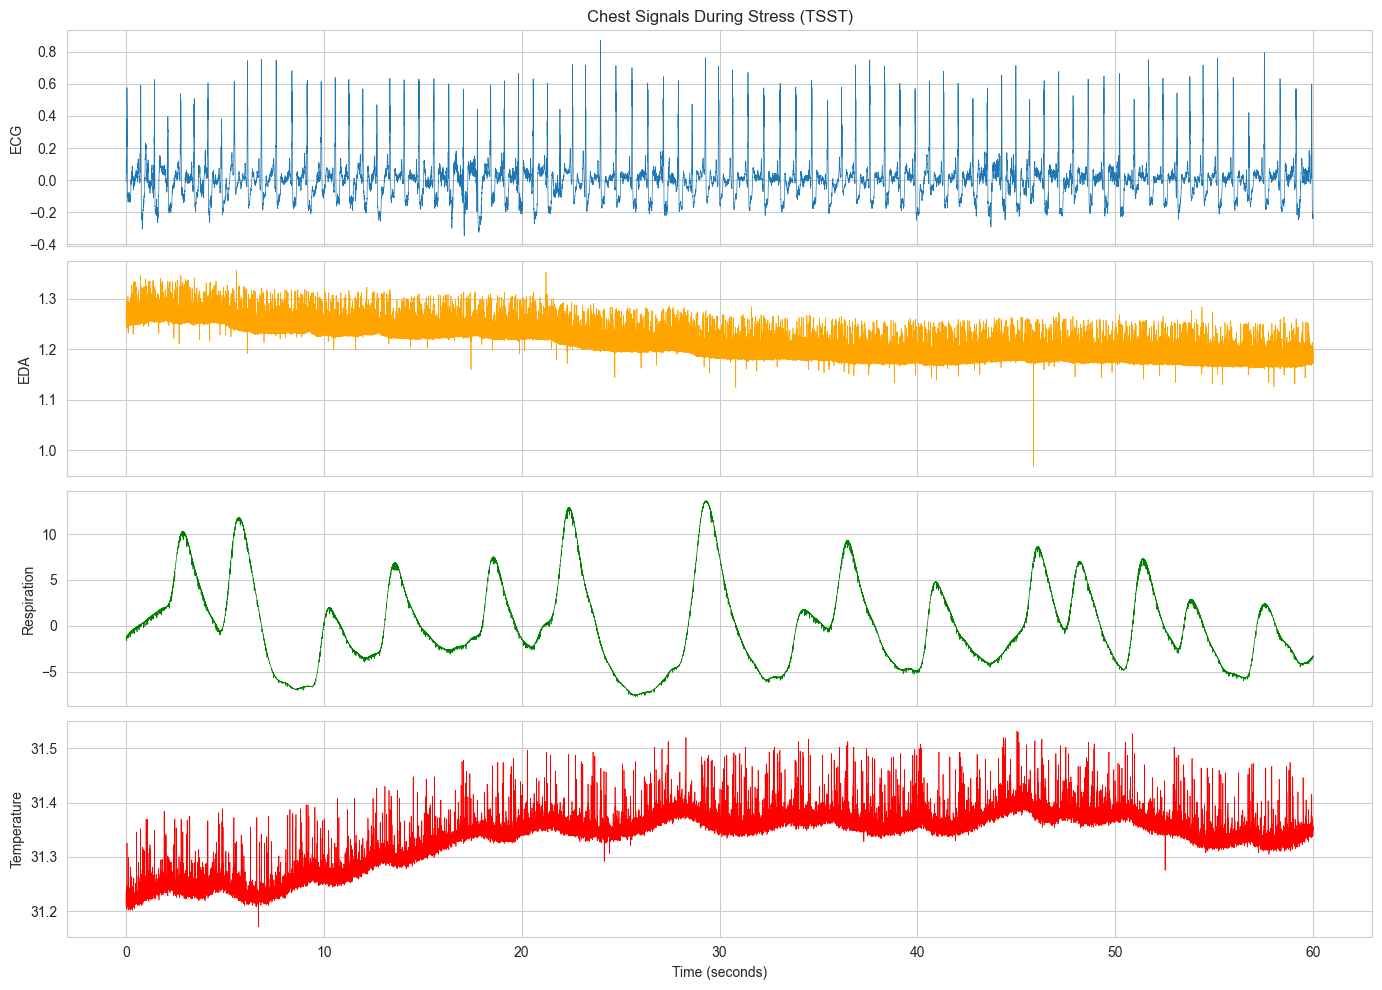

In [9]:
# Plot a sample of chest signals
sample_duration = 60  # seconds
fs = 700  # sampling frequency for chest (Hz)
n_samples = sample_duration * fs

# Select a portion during stress (label == 2)
stress_indices = np.where(labels == 2)[0]
if len(stress_indices) > n_samples:
    start_idx = stress_indices[0]
    end_idx = start_idx + n_samples
    
    time = np.arange(n_samples) / fs
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    # ECG
    if 'ECG' in chest:
        axes[0].plot(time, chest['ECG'][start_idx:end_idx], linewidth=0.5)
        axes[0].set_ylabel('ECG')
        axes[0].set_title('Chest Signals During Stress (TSST)')
    
    # EDA
    if 'EDA' in chest:
        axes[1].plot(time, chest['EDA'][start_idx:end_idx], linewidth=0.5, color='orange')
        axes[1].set_ylabel('EDA')
    
    # Respiration
    if 'Resp' in chest:
        axes[2].plot(time, chest['Resp'][start_idx:end_idx], linewidth=0.5, color='green')
        axes[2].set_ylabel('Respiration')
    
    # Temperature
    if 'Temp' in chest:
        axes[3].plot(time, chest['Temp'][start_idx:end_idx], linewidth=0.5, color='red')
        axes[3].set_ylabel('Temperature')
        axes[3].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough stress data to plot")

## 6. Load Multiple Subjects

In [10]:
# Get all available subjects
subject_dirs = sorted([d for d in DATA_DIR.iterdir() if d.is_dir() and d.name.startswith('S')])
subject_ids = [d.name for d in subject_dirs]

print(f"Available subjects: {subject_ids}")
print(f"Total subjects: {len(subject_ids)}")

Available subjects: ['S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9']
Total subjects: 15


In [11]:
# Load all subjects (this may take time and memory)
# Uncomment to load all subjects

# all_subjects_data = {}
# for subject_id in subject_ids:
#     try:
#         all_subjects_data[subject_id] = load_wesad_subject(subject_id)
#         print(f"Loaded {subject_id}")
#     except Exception as e:
#         print(f"Error loading {subject_id}: {e}")

# print(f"\nSuccessfully loaded {len(all_subjects_data)} subjects")

## 7. Load Questionnaire Data

In [12]:
def load_subject_metadata(subject_id):
    """
    Load subject metadata from readme file.
    """
    if isinstance(subject_id, int):
        subject_id = f'S{subject_id}'
    
    readme_path = DATA_DIR / subject_id / f'{subject_id}_readme.txt'
    
    metadata = {}
    if readme_path.exists():
        with open(readme_path, 'r') as f:
            for line in f:
                if ':' in line and not line.startswith('#'):
                    key, value = line.split(':', 1)
                    metadata[key.strip()] = value.strip()
    
    return metadata

# Example: load metadata for S2
metadata = load_subject_metadata('S2')
print("Subject S2 metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Subject S2 metadata:
  Age: 27
  Height (cm): 175
  Weight (kg): 80
  Gender: male
  Dominant hand: right


## 8. Summary Statistics

In [13]:
# Basic statistics for chest signals
print("Chest signal statistics:")
print(chest_df.describe())

Chest signal statistics:
                ECG           EDA           EMG          Temp          Resp  \
count  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06  4.255300e+06   
mean   1.212245e-03  1.528387e+00 -2.412918e-03  3.087667e+01  5.490614e-02   
std    1.540773e-01  1.238425e+00  1.165187e-02  1.281106e+00  2.917749e+00   
min   -1.499542e+00  2.632141e-01 -4.149628e-01  2.804526e+01 -2.790375e+01   
25%   -6.797791e-02  7.995605e-01 -8.331299e-03  3.057495e+01 -1.481628e+00   
50%    8.239746e-03  1.163101e+00 -1.602173e-03  3.128992e+01 -1.571655e-01   
75%    4.435730e-02  1.546478e+00  3.982544e-03  3.181512e+01  1.618958e+00   
max    1.499313e+00  7.576752e+00  3.009796e-01  3.437039e+01  2.737885e+01   

              label  
count  4.255300e+06  
mean   1.212370e+00  
std    1.606596e+00  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    2.000000e+00  
max    7.000000e+00  


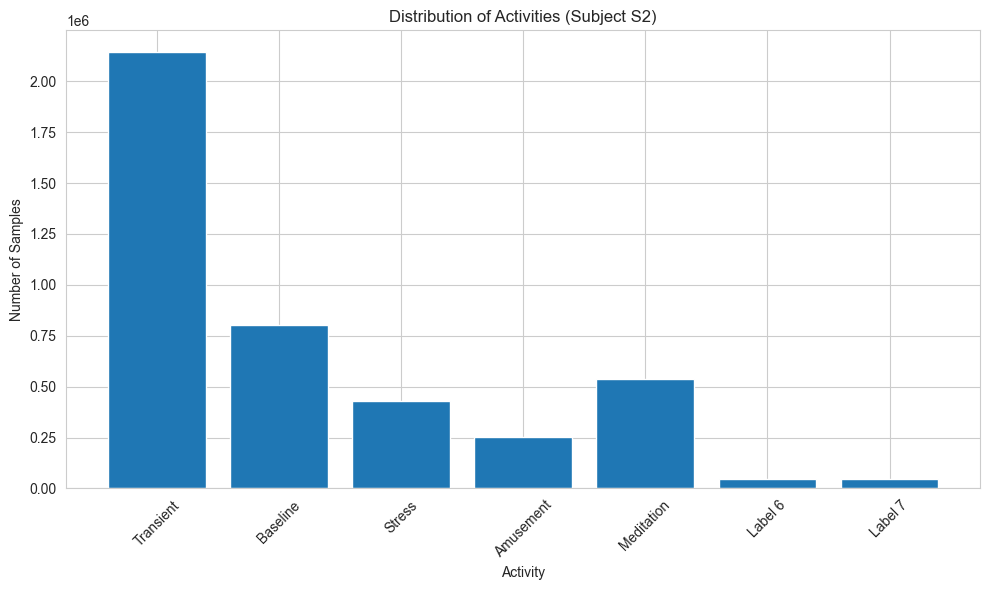

In [14]:
# Visualize label distribution
if 'label' in chest_df.columns:
    plt.figure(figsize=(10, 6))
    label_counts = chest_df['label'].value_counts().sort_index()
    
    label_names = {
        0: 'Transient',
        1: 'Baseline',
        2: 'Stress',
        3: 'Amusement',
        4: 'Meditation'
    }
    
    labels_plot = [label_names.get(i, f'Label {i}') for i in label_counts.index]
    
    plt.bar(labels_plot, label_counts.values)
    plt.xlabel('Activity')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Activities (Subject S2)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Key Features of the Updated Notebook:
1. WESAD Data Loading
Function to load subject 
.pkl
 files using pickle
Handles both chest (RespiBAN) and wrist (Empatica E4) devices
Proper error handling for missing files
2. Signal Extraction
Chest signals: ECG, EDA, EMG, Temperature, Respiration (700 Hz)
Wrist signals: BVP, EDA, Temperature, Accelerometer (various rates)
Converts signals to pandas DataFrames for easier analysis
3. Label Handling
Loads activity labels (Baseline, Stress, Amusement, Meditation)
Displays label distribution and counts
Maps numeric labels to meaningful names
4. Visualization
Plots physiological signals over time
Shows stress period examples
Bar charts for label distribution
5. Metadata Loading
Function to parse subject readme files
Extracts age, gender, height, weight, etc.
6. Multi-Subject Support
Code to identify all available subjects
Template for loading multiple subjects


## Next Steps

1. **Feature Engineering**: Extract features from raw signals (heart rate, HRV, EDA features, etc.)
2. **Data Preprocessing**: Handle missing values, normalize signals, segment data
3. **Cross-subject Analysis**: Compare signals across different subjects
4. **Stress Detection**: Build models to classify stress vs. baseline/other states
5. **Time Series Analysis**: Analyze temporal patterns in physiological signals